# Brain Tumor Volumetric Segmentation in Multimodal MRI Using 3D CNN 
### MedU-net arquitecture
by José L. Rondo


In [1]:
import time
import numpy as np  # For data manipulation
from keras.optimizers import *
from keras.callbacks import *
from MedUnet_model import build_MedUnet
from model_metrics import dice_coefficient, sensitivity, specificity, loss_gt
from results_visualization import predictVolume, show_segmented_image

In [2]:
#We defined some hyperparameters
input_shape = (4, 112, 160, 128) #Our input resolution
data_format = 'channels_first' 
output_channels = 3 #Each channel for each glioma subregion
kernel_size=3 #Kernel size for convolution block
conc_kernel=1 #Kernel size for concatenation block
n_filters=16 #nro de filters for convolution block
conc_filters=32 #nro de filters for concatenation block
dropout=0.2
lr = 1e-4

In [4]:
data_train = np.load('./ProjectTesis_Data/FinalData/data_trainMR.npy')
labels_train = np.load('./ProjectTesis_Data/FinalData/labels_trainMR.npy')

In [2]:
data_test = np.load('./ProjectTesis_Data/FinalData/data_testMR.npy')
labels_test = np.load('./ProjectTesis_Data/FinalData/labels_testMR.npy') 

Build the model

In [3]:
#The last parameter "True" means that group normalization layer was used
model = build_MedUnet(input_shape, output_channels, n_filters, conc_filters, 
                      kernel_size, conc_kernel, dropout, True)

Compile the model

In [5]:
model.compile(loss=[loss_gt(1e-8)],
        metrics=[dice_coefficient, 'Precision', sensitivity, specificity], 
              optimizer = Adam(lr))

In [6]:
#You can uncomment:
#"EarlyStopping" to stop the training if "val_los" does not improve in "patience" epochs.
#"ReduceLROnPlateau" to reduce Learning Rate (lr=1e-4 in our case) if "val_los" does not improve in "patience" epochs.
#"ModelCheckpoint" to save your best model during training.
callbacks = [
    #EarlyStopping(monitor="val_loss",mode="min", patience=50, verbose=1),
    #ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.1, patience=50, min_lr=0.000001, verbose=1),
    #ModelCheckpoint('./ProjectTesis_Data/unet_Tesis_V4.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

Train the model

In [7]:
#Due to GPU limitations batch size was set to 1.
#we use 300 epochs in our training, you can modify this value whether you think convenience.
t0 = time.time()
print('Entrenando modelo...')
print('')

history = model.fit(data_train, labels_train, batch_size=1, epochs=5,
                   validation_split=0.1, callbacks=callbacks)

t= time.time()
t_trans = t-t0
print('Entrenamiento finalizado tras', t_trans/60, 'minutos.')

Entrenando modelo...

Epoch 1/5
300/300 [==============================] - 286s 891ms/step - loss: 0.8872 - dice_coefficient: 0.1128 - precision: 0.0372 - sensitivity: 0.7864 - specificity: 0.6450 - val_loss: 0.7629 - val_dice_coefficient: 0.2371 - val_precision: 0.3385 - val_sensitivity: 0.7733 - val_specificity: 0.9705
Epoch 2/5
300/300 [==============================] - 268s 893ms/step - loss: 0.6777 - dice_coefficient: 0.3223 - precision: 0.3341 - sensitivity: 0.8577 - specificity: 0.9756 - val_loss: 0.7216 - val_dice_coefficient: 0.2784 - val_precision: 0.4339 - val_sensitivity: 0.7269 - val_specificity: 0.9810
Epoch 3/5
300/300 [==============================] - 268s 893ms/step - loss: 0.6167 - dice_coefficient: 0.3833 - precision: 0.3870 - sensitivity: 0.8424 - specificity: 0.9825 - val_loss: 0.6740 - val_dice_coefficient: 0.3260 - val_precision: 0.4910 - val_sensitivity: 0.6594 - val_specificity: 0.9872
Epoch 4/5
300/300 [==============================] - 266s 888ms/step - loss

Metrics after training

In [10]:
score = model.evaluate(data_test, labels_test, batch_size=1, verbose=1)
print(model.metrics_names)
print(f'Test loss: {score[0]} / Test DICE: {score[1]}')

35/35 [==============================] - 7s 193ms/step - loss: 0.4226 - dice_coefficient: 0.5774 - precision: 0.5081 - sensitivity: 0.8275 - specificity: 0.9873
['loss', 'dice_coefficient', 'precision', 'sensitivity', 'specificity']
Test loss: 0.42258691787719727 / Test DICE: 0.577413022518158


In [11]:
prediction=model.predict(data_test, batch_size=1, verbose=1)

35/35 [==============================] - 8s 200ms/step


Save your predicctions to show later

In [ ]:
np.save('./ProjectTesis_Data/FinalData/prediccion#PATs35_BS1_E369_DICE08524.npy',prediction)

Visualization Section

In [3]:
#We need to load "data_test" and "labels_test" for visualization
T1c=data_test[29]
predictions = np.load('./ProjectTesis_Data/FinalData/prediccion#PATs35_BS1_E369_DICE08524.npy') 

In [4]:
predictions.shape #We obtain 35 predictions i.e. 35 glioma segmentations

(35, 3, 112, 160, 128)

In [5]:
#we choose any patient between 0-34 (35 in total)
#Our predicctions has three channels which each one represent a diferent glioma subregion.
# 0==> Necrosis and nonenhancing tumor core
# 1==> Peritumoral Edema
# 2==> Enhancing Tumor Core
imgTarget0 = predictions[29][0]
imgTarget1 = predictions[29][1]
imgTarget2 = predictions[29][2]
GT_Target0 = labels_test[29][0]
GT_Target1 = labels_test[29][1]
GT_Target2 = labels_test[29][2]

In [6]:
#Obtain the volume of each subregion to show
predImg0 = predictVolume(imgTarget0)
predImg1 = predictVolume(imgTarget1)
predImg2 = predictVolume(imgTarget2)
GTImg0 = predictVolume(GT_Target0)
GTImg1 = predictVolume(GT_Target1)
GTImg2 = predictVolume(GT_Target2)

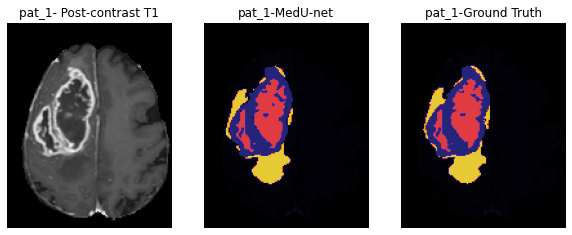

In [8]:
show_segmented_image(predImg0, predImg1, predImg2, GTImg0, GTImg1, GTImg2, T1c, modality='t1c', show = True)